In [145]:
from IPython.display import Image, Video
from agents import *
from utils import EpsilonGreedy
from utils.agent_metrics_comparer import AgentMetricsComparer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Documentations / References.

Documentation on gym / gymnasium can be found here: [https://gymnasium.farama.org/api/env/], it has good documentation on all the functions. - Do not use the one "showed" in exam paper: [https://www.gymlibrary.dev/index.html], since it has pretty bad documentation.

## NOTE!

You will determine how the notebook runs by modifying the variables below:<br>
`SHOULD_TRAIN` => If the agents should re-train at the bottom of the notebook or not. NOTE: setting this to `True` will re-train agents: Graps etc will differ!<br>
`TRAIN_EPISODES` => How many episodes the agents will train on.<br>
`MAX_STEPS_PER_EPISODE` => How many steps the agent will maximum be allowed to take before an episode terminates.<br>
`WATCH_EPISODES` => if `True` the episodes will render on the screen real-time ran by the agents.<br>
`RENDER_MODE` => How the environment should render its episode when watching it.<br>
`RECORD_N_EPISODES` => How many episodes to record into `static/movies`.<br>

**NOTE** If you do not want to see the agents in real-time, it is fine, because there is a pre-recorded video of each agent under the subsequent sections. They are recorded after the agent is trained in the `taxi_agent.record_video`.

In [146]:
SHOULD_TRAIN = False
TRAIN_EPISODES = 2500
MAX_STEPS_PER_EPISODE = 200
WATCH_EPISODES = False
RENDER_MODE = 'human'
RECORD_N_EPISODES = 3

# [TASK-1] Overview of the Environment.

## Grid

The taxi can move on all nodes except $X$.

For each step it takes, it will be given $-1$ rewards, if successfully deliver passenger $+20$ reward points is granted. On failure on pickup and dropoff $-10$ reward points are granted.

$$
\begin{bmatrix}
\text{RED}_{11} & x_{12} & \text{X} & x_{14} & \text{GREEN}_{15} \\
x_{21} & x_{22} & \text{X} & x_{24} & x_{25} \\
x_{31} & x_{32} & x_{33} & x_{34} & x_{35} \\
x_{41} & \text{X} & x_{43} & x_{44} & x_{45} \\
\text{YELLOW}_{51} & \text{X} & x_53 & \text{BLUE}_{54} & x_{55}
\end{bmatrix}
$$

## Actions
0: move south

1: move north

2: move east

3: move west

4: pickup passenger

5: drop off passenger

## Observation space.

The taxi can dropoff passanger on (0)$\text{RED}_{11}$, (1)$\text{GREEN}_{15}$, (2)$\text{YELLOW}_{51}$, (3)$\text{BLUE}_{54}$.
That means that the passanger can be on all these states, and additionally (4)$\text{in taxi}$.

The grid is **5x5** resulting in **25** different locations for the taxi.

$4_{destinations} * 5_{passanger_locations} * 25_{nodes} = 500_{states}$

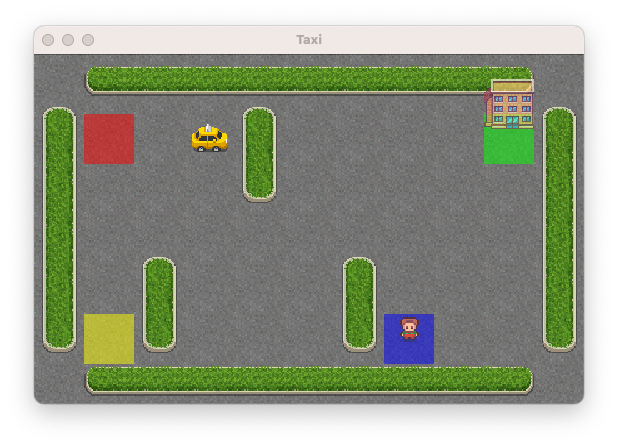

In [147]:
Image(filename='./static/Environment.png')

# Hyperparameter Discovery

In [148]:
basic_params = pd.read_csv('./static/metrics/basic_tune_metrics.csv')
sarsa_params = pd.read_csv('./static/metrics/sarsa_tune_metrics.csv')

In [149]:
basic_params.corr()

,epsilon_decay,learning_rate,discount_factor,score_min,score_avg,score_max,step_min,step_avg,step_max,time_min,time_avg,time_max
epsilon_decay,1.000000,-0.229395,-0.117348,-0.153572,-0.708709,NaN,NaN,0.374481,NaN,-0.030330,0.372740,-0.062552
learning_rate,-0.229395,1.000000,0.174956,0.037321,0.716479,NaN,NaN,-0.812380,NaN,0.057150,-0.803183,-0.030970
discount_factor,-0.117348,0.174956,1.000000,0.050869,0.192362,NaN,NaN,-0.216878,NaN,-0.087906,-0.233749,-0.054348
score_min,-0.153572,0.037321,0.050869,1.000000,0.157852,NaN,NaN,-0.106933,NaN,0.055415,-0.093959,0.102826
score_avg,-0.708709,0.716479,0.192362,0.157852,1.000000,NaN,NaN,-0.894871,NaN,0.056019,-0.887261,0.022395
score_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
step_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
step_avg,0.374481,-0.812380,-0.216878,-0.106933,-0.894871,NaN,NaN,1.000000,NaN,-0.067504,0.988699,0.019428
step_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_min,-0.030330,0.057150,-0.087906,0.055415,0.056019,NaN,NaN,-0.067504,NaN,1.000000,0.065020,0.398036


In [150]:
sarsa_params.corr()

,epsilon_decay,learning_rate,discount_factor,score_min,score_avg,score_max,step_min,step_avg,step_max,time_min,time_avg,time_max
epsilon_decay,1.000000,0.092698,-0.211128,-0.130119,-0.501488,0.077500,-0.077500,0.312081,NaN,-0.036854,0.315126,0.128778
learning_rate,0.092698,1.000000,-0.014857,-0.048230,-0.206269,0.043933,-0.043933,0.193472,NaN,0.024827,0.194480,0.079224
discount_factor,-0.211128,-0.014857,1.000000,0.034725,0.852915,0.134497,-0.134497,-0.892767,NaN,-0.241098,-0.893069,-0.303012
score_min,-0.130119,-0.048230,0.034725,1.000000,0.014872,0.178483,-0.178483,0.016753,NaN,-0.202521,0.009578,-0.035386
score_avg,-0.501488,-0.206269,0.852915,0.014872,1.000000,0.059682,-0.059682,-0.973843,NaN,-0.170450,-0.973681,-0.366561
score_max,0.077500,0.043933,0.134497,0.178483,0.059682,1.000000,-1.000000,-0.084289,NaN,-0.771186,-0.097469,-0.272383
step_min,-0.077500,-0.043933,-0.134497,-0.178483,-0.059682,-1.000000,1.000000,0.084289,NaN,0.771186,0.097469,0.272383
step_avg,0.312081,0.193472,-0.892767,0.016753,-0.973843,-0.084289,0.084289,1.000000,NaN,0.192909,0.998692,0.373303
step_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_min,-0.036854,0.024827,-0.241098,-0.202521,-0.170450,-0.771186,0.771186,0.192909,NaN,1.000000,0.223624,0.389981


In [151]:
basic_hyper = basic_params.loc[np.argmax(basic_params['score_avg'])]
sarsa_hyper = sarsa_params.loc[np.argmax(sarsa_params['score_avg'])]

In [152]:
agents = {
    'random': RandomPolicyAgent(),
    'heuristic': HeuristicPolicyAgent(),
    'basic': BasicQAgent(EpsilonGreedy(1.0, basic_hyper['epsilon_decay'], 0.0), basic_hyper['learning_rate'], basic_hyper['discount_factor']),
    'sarsa': SarsaAgent(EpsilonGreedy(1.0, sarsa_hyper['epsilon_decay'], 0.0), sarsa_hyper['learning_rate'], sarsa_hyper['discount_factor']),
    'dql': DeepQAgent(EpsilonGreedy(1.0, 0.998, 0.0), 0.0001, 0.95, 258, 25000),
}

# Watch the agents play real-time

If you want to watch the agents solve the environment in real-time, then feel free to run the agents below. **Be aware you do need to have Pygame installed**

Else, you're free to watch a recorded video of the algorithm under its respected section below.

In [153]:
if WATCH_EPISODES:
    for name, agent in agents.items():
        agent.watch(n_episodes=1, step_limit_per_episode=40, mode=RENDER_MODE)

# Analysis of the agents performance

We've solved the environment with Q-Learning, SARSA, and Deep-Q-Learning in addition to the Random Policy and Heuristic Policy.

All agents are pre-trained with a total of **2_500 Episodes** on a computer with the specs:

**CPU**: AMD Ryzen 9 7950X3D, 32-Thread, 4.2/5.7 GHz.

**GPU**: NVIDIA GeForce RTX 4080 SUPER, 16GB GDDR6X, 2640 MHz, 10_420 Cuda Cores. (Used for training the Neural Net with TensorFlow)

**RAM**: DDR5 6000MHz 64GB, AMD EXPO, CL30-36-36-76

In [154]:
metrics = AgentMetricsComparer(dir_name='static/metrics')

# Random Policy

In [155]:
metrics['random'].describe()

,rewards,steps,epsilon,time
count,2500.000000,2500.000000,2500.0,2500.000000
mean,-772.566400,196.692400,1.0,0.001245
std,100.473963,17.803252,0.0,0.000164
min,-1019.000000,25.000000,1.0,0.000185
25%,-830.000000,200.000000,1.0,0.001163
50%,-785.000000,200.000000,1.0,0.001187
75%,-740.000000,200.000000,1.0,0.001417
max,-76.000000,200.000000,1.0,0.001571


In [156]:
metrics['random'].corr()

,rewards,steps,epsilon,time
rewards,1.000000,-0.770604,NaN,-0.518639
steps,-0.770604,1.000000,NaN,0.664551
epsilon,NaN,NaN,NaN,NaN
time,-0.518639,0.664551,NaN,1.000000


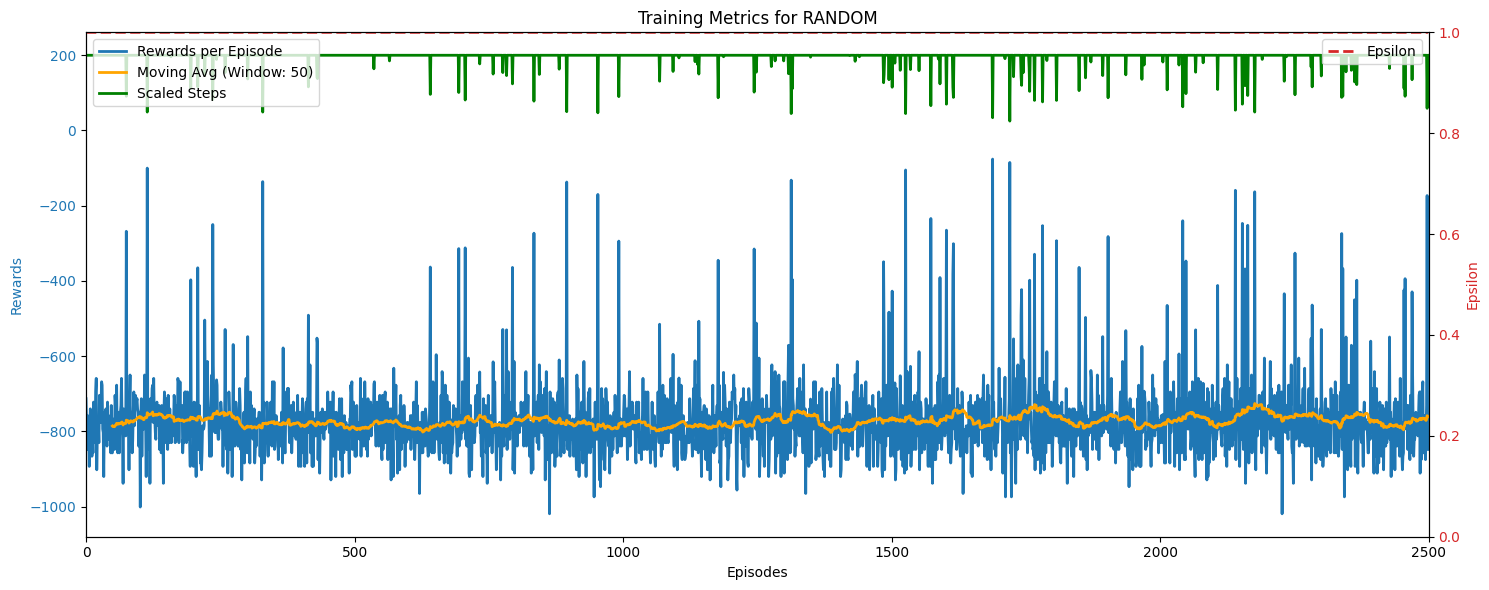

In [157]:
metrics.plot_metric('random')

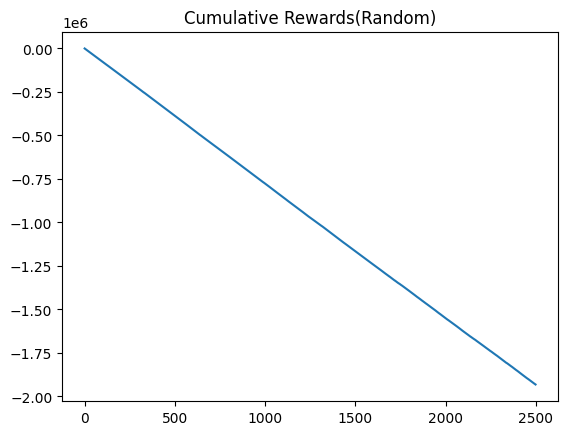

In [158]:
plt.plot(metrics['random'].loc[:,'rewards'].cumsum())
plt.title("Cumulative Rewards(Random)")
plt.show()

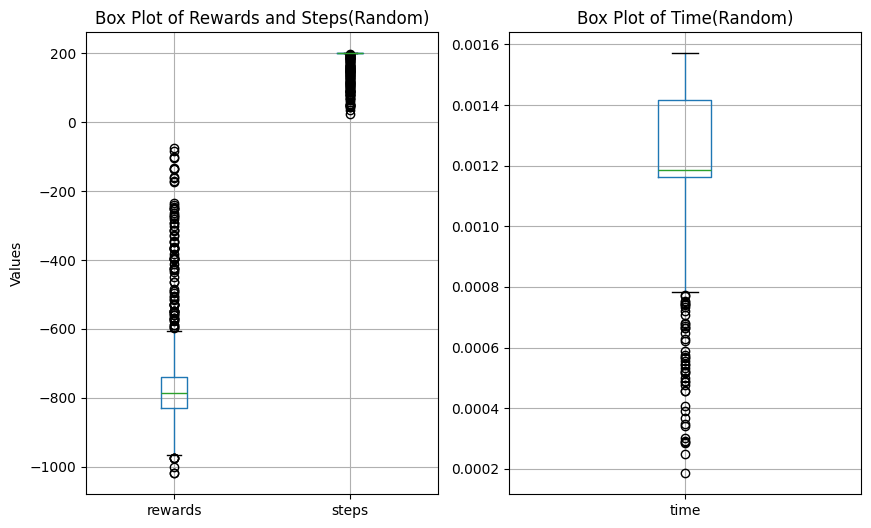

In [159]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
metrics['random'][['rewards', 'steps']].boxplot(ax=axs[0])
metrics['random'][['time']].boxplot(ax=axs[1])
axs[0].set_title("Box Plot of Rewards and Steps(Random)")
axs[1].set_title("Box Plot of Time(Random)")
axs[0].set_ylabel("Values")
plt.show()

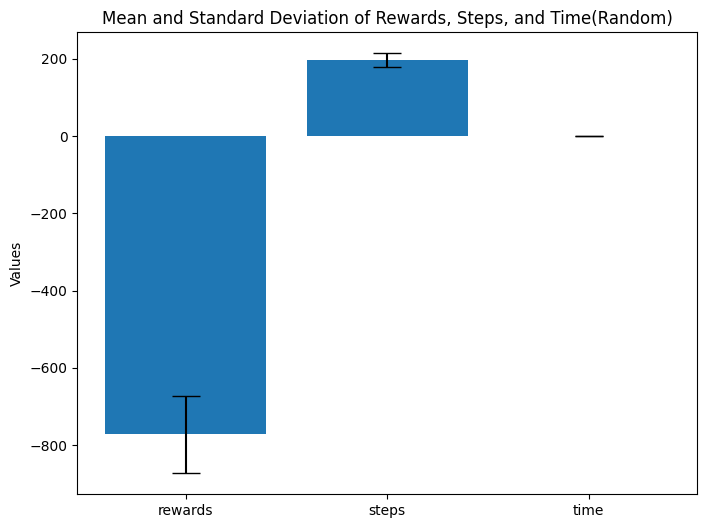

In [160]:
means = metrics['random'][['rewards', 'steps', 'time']].mean()
stds = metrics['random'][['rewards', 'steps', 'time']].std()

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(means.index, means, yerr=stds, capsize=10)
ax.set_title("Mean and Standard Deviation of Rewards, Steps, and Time(Random)")
ax.set_ylabel("Values")

plt.show()

In [161]:
Video('./static/movies/random/rl-video-episode-0.mp4')

# Heuristic Policy

In [162]:
metrics['heuristic'].describe()

,rewards,steps,epsilon,time
count,2500.000000,2500.000000,2500.0,2500.000000
mean,-175.236000,177.722400,0.0,0.001015
std,67.594697,60.809417,0.0,0.000357
min,-200.000000,6.000000,0.0,0.000042
25%,-200.000000,200.000000,0.0,0.001071
50%,-200.000000,200.000000,0.0,0.001093
75%,-200.000000,200.000000,0.0,0.001117
max,15.000000,200.000000,0.0,0.001637


In [163]:
metrics['heuristic'].corr()

,rewards,steps,epsilon,time
rewards,1.000000,-0.999999,NaN,-0.963511
steps,-0.999999,1.000000,NaN,0.963515
epsilon,NaN,NaN,NaN,NaN
time,-0.963511,0.963515,NaN,1.000000


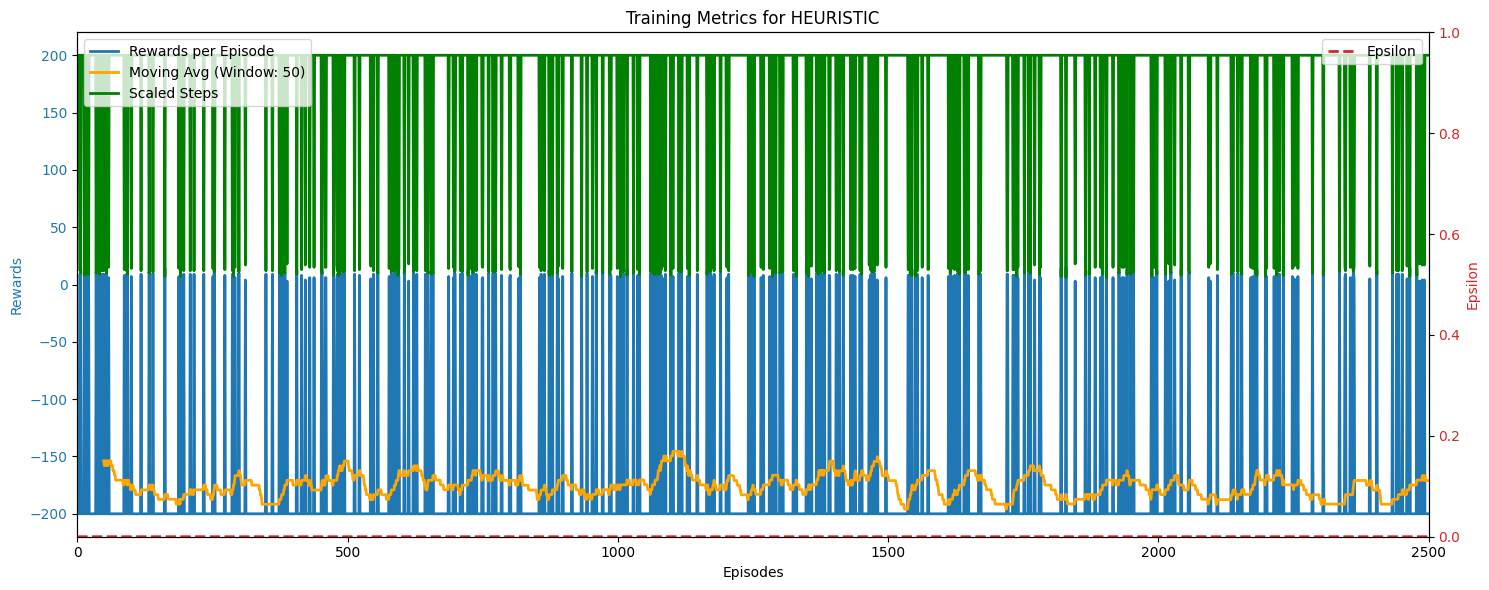

In [164]:
metrics.plot_metric('heuristic')

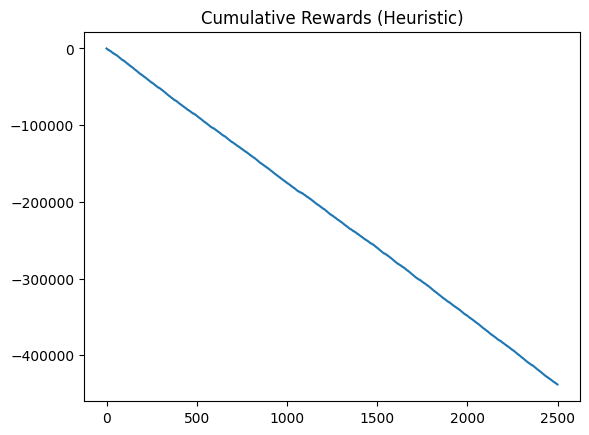

In [165]:
plt.plot(metrics['heuristic'].loc[:,'rewards'].cumsum())
plt.title("Cumulative Rewards (Heuristic)")
plt.show()

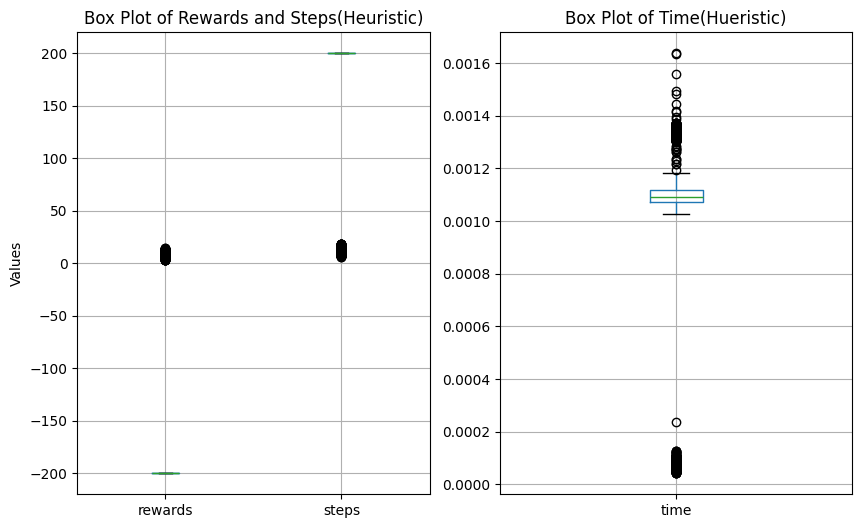

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
metrics['heuristic'][['rewards', 'steps']].boxplot(ax=axs[0])
metrics['heuristic'][['time']].boxplot(ax=axs[1])
axs[0].set_title("Box Plot of Rewards and Steps(Heuristic)")
axs[1].set_title("Box Plot of Time(Hueristic)")
axs[0].set_ylabel("Values")
plt.show()

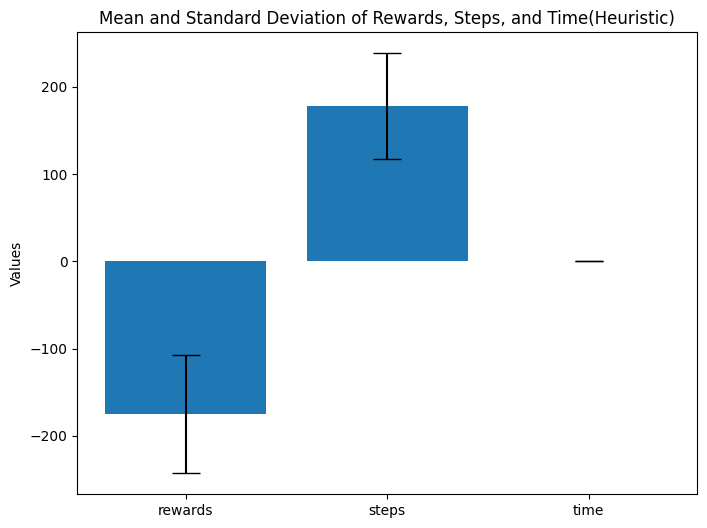

In [167]:
means = metrics['heuristic'][['rewards', 'steps', 'time']].mean()
stds = metrics['heuristic'][['rewards', 'steps', 'time']].std()

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(means.index, means, yerr=stds, capsize=10)
ax.set_title("Mean and Standard Deviation of Rewards, Steps, and Time(Heuristic)")
ax.set_ylabel("Values")

plt.show()

In [168]:
Video('./static/movies/heuristic/rl-video-episode-0.mp4')

# Q-Learning Policy

In [169]:
metrics['basic'].describe()

,rewards,steps,epsilon,time
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,-33.192000,26.670000,0.079669,0.000225
std,141.942475,42.219641,0.182759,0.000349
min,-902.000000,6.000000,0.000004,0.000054
25%,3.000000,12.000000,0.000083,0.000102
50%,7.000000,14.000000,0.001906,0.000121
75%,9.000000,17.000000,0.043548,0.000147
max,15.000000,200.000000,0.995004,0.001905


In [170]:
metrics['basic'].corr()

,rewards,steps,epsilon,time
rewards,1.000000,-0.972964,-0.905885,-0.975386
steps,-0.972964,1.000000,0.896742,0.999421
epsilon,-0.905885,0.896742,1.000000,0.898195
time,-0.975386,0.999421,0.898195,1.000000


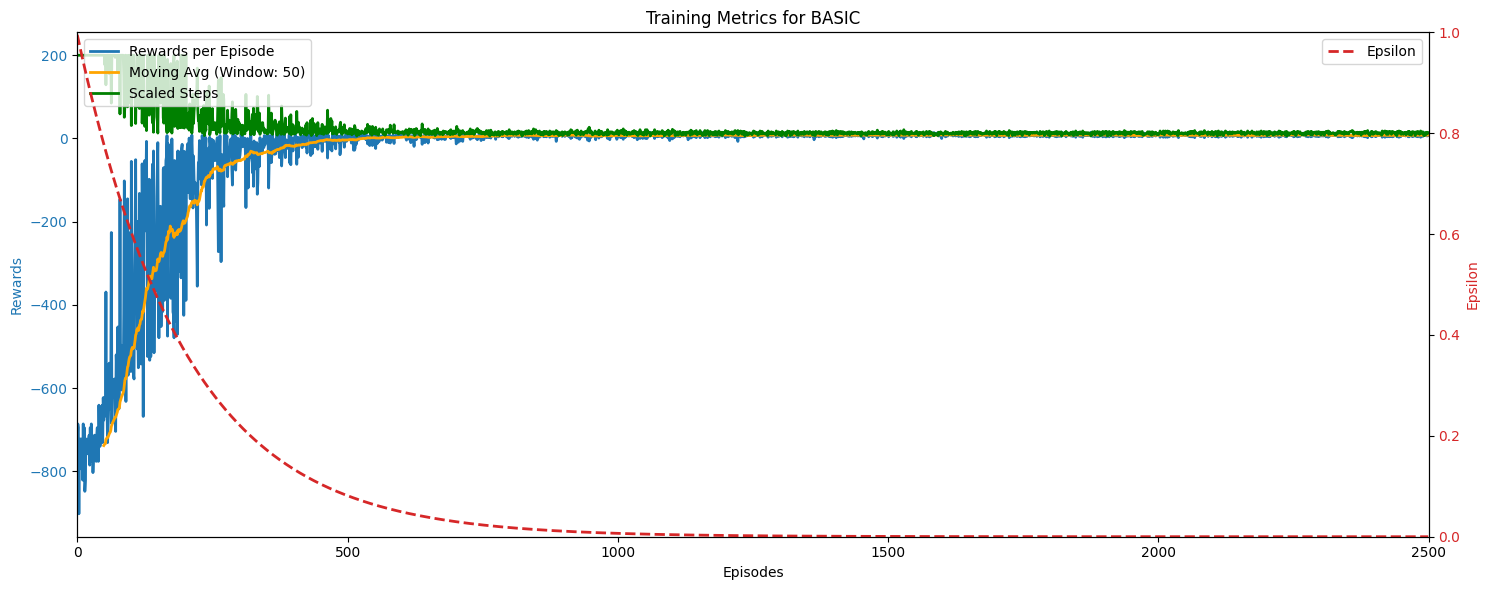

In [171]:
metrics.plot_metric('basic')

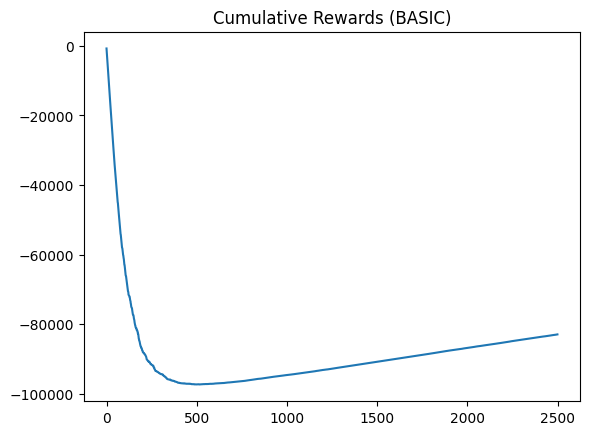

In [172]:
plt.plot(metrics['basic'].loc[:,'rewards'].cumsum())
plt.title("Cumulative Rewards (BASIC)")
plt.show()

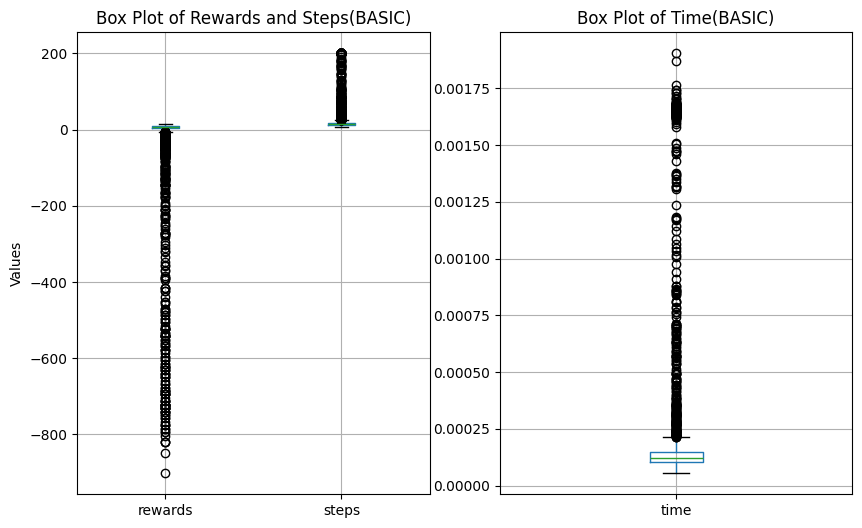

In [173]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
metrics['basic'][['rewards', 'steps']].boxplot(ax=axs[0])
metrics['basic'][['time']].boxplot(ax=axs[1])
axs[0].set_title("Box Plot of Rewards and Steps(BASIC)")
axs[1].set_title("Box Plot of Time(BASIC)")
axs[0].set_ylabel("Values")
plt.show()

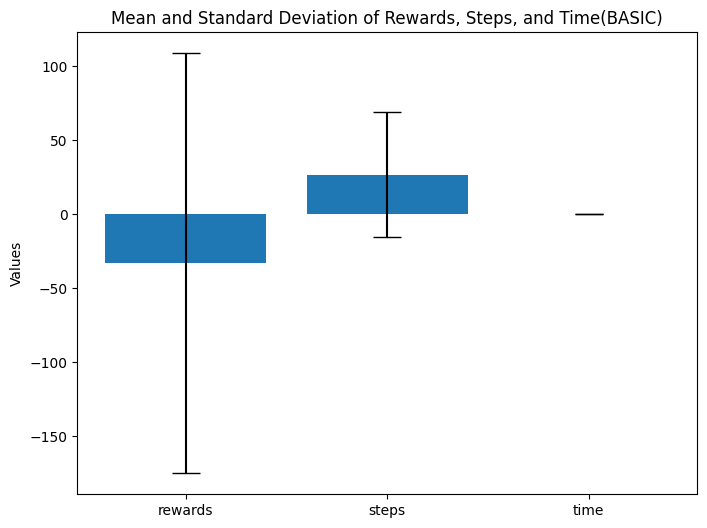

In [174]:
means = metrics['basic'][['rewards', 'steps', 'time']].mean()
stds = metrics['basic'][['rewards', 'steps', 'time']].std()

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(means.index, means, yerr=stds, capsize=10)
ax.set_title("Mean and Standard Deviation of Rewards, Steps, and Time(BASIC)")
ax.set_ylabel("Values")

plt.show()

In [175]:
Video('./static/movies/basic/rl-video-episode-0.mp4')

# SARSA Policy

In [176]:
metrics['sarsa'].describe()

,rewards,steps,epsilon,time
count,2500.00000,2500.000000,2500.000000,2500.000000
mean,-43.28640,31.510800,0.079650,0.000217
std,153.69166,49.629047,0.182742,0.000340
min,-857.00000,6.000000,0.000004,0.000041
25%,3.00000,12.000000,0.000083,0.000085
50%,6.00000,15.000000,0.001903,0.000100
75%,9.00000,17.000000,0.043516,0.000120
max,15.00000,200.000000,0.995003,0.001553


In [177]:
metrics['sarsa'].corr()

,rewards,steps,epsilon,time
rewards,1.000000,-0.961001,-0.927054,-0.962955
steps,-0.961001,1.000000,0.881334,0.999313
epsilon,-0.927054,0.881334,1.000000,0.886523
time,-0.962955,0.999313,0.886523,1.000000


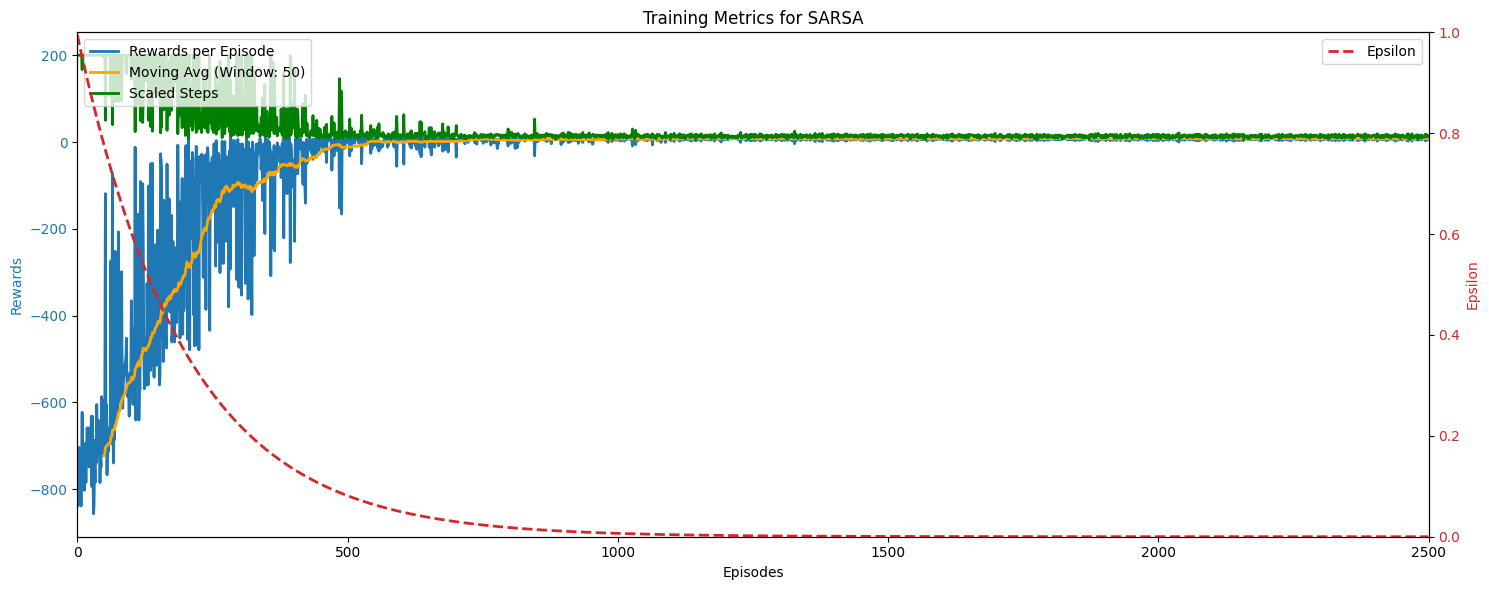

In [178]:
metrics.plot_metric('sarsa')

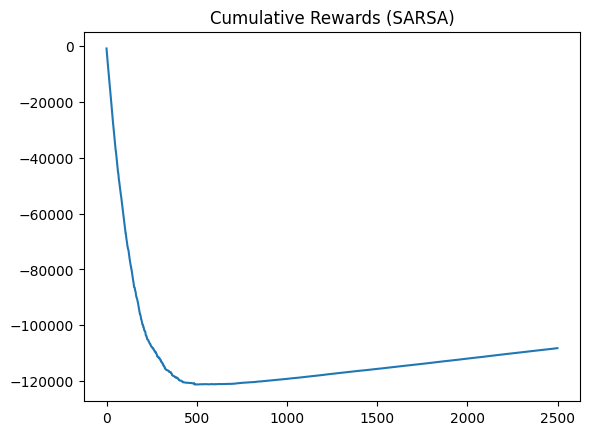

In [179]:
plt.plot(metrics['sarsa'].loc[:,'rewards'].cumsum())
plt.title("Cumulative Rewards (SARSA)")
plt.show()

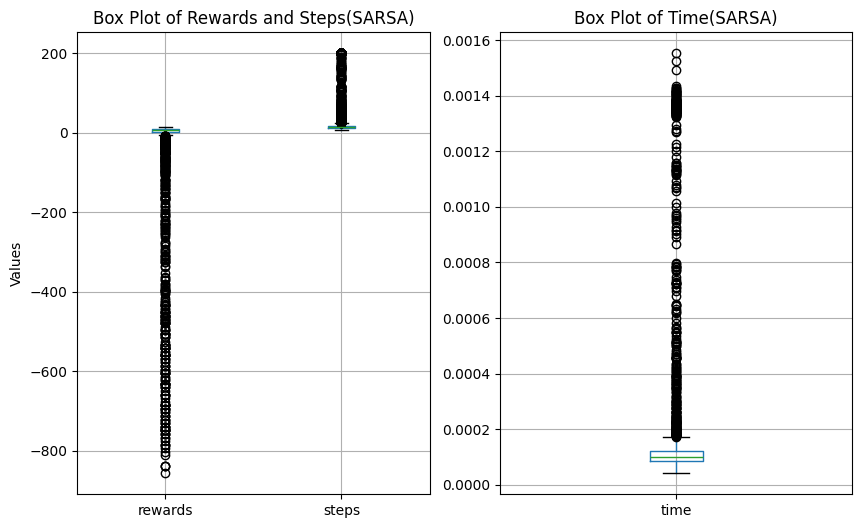

In [180]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
metrics['sarsa'][['rewards', 'steps']].boxplot(ax=axs[0])
metrics['sarsa'][['time']].boxplot(ax=axs[1])
axs[0].set_title("Box Plot of Rewards and Steps(SARSA)")
axs[1].set_title("Box Plot of Time(SARSA)")
axs[0].set_ylabel("Values")
plt.show()

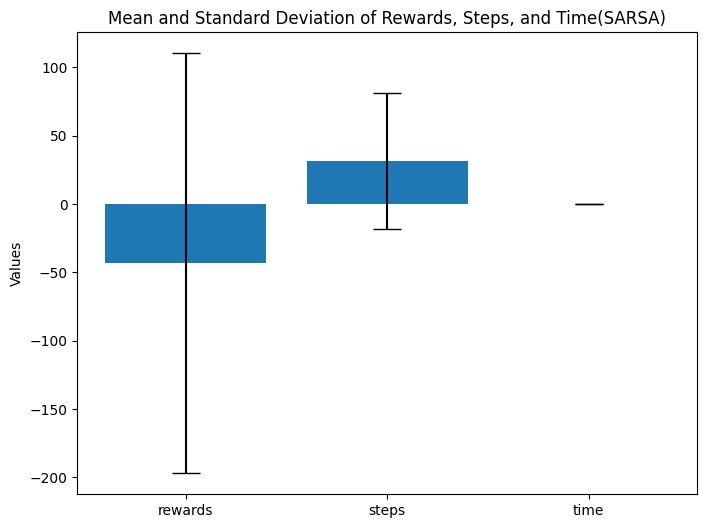

In [181]:
means = metrics['sarsa'][['rewards', 'steps', 'time']].mean()
stds = metrics['sarsa'][['rewards', 'steps', 'time']].std()

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(means.index, means, yerr=stds, capsize=10)
ax.set_title("Mean and Standard Deviation of Rewards, Steps, and Time(SARSA)")
ax.set_ylabel("Values")

plt.show()

In [182]:
Video('./static/movies/sarsa/rl-video-episode-0.mp4')

# Deep Q Network

In [183]:
metrics['dql'].describe()

,rewards,steps,epsilon,time
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,-44.800000,27.238000,0.198262,0.070259
std,155.232382,40.184645,0.245789,0.069271
min,-902.000000,6.000000,0.006704,0.001487
25%,-14.000000,13.000000,0.023418,0.043540
50%,5.000000,15.000000,0.081798,0.051706
75%,8.000000,20.000000,0.285717,0.062676
max,15.000000,200.000000,0.998000,1.411998


In [184]:
metrics['dql'].corr()

,rewards,steps,epsilon,time
rewards,1.000000,-0.989630,-0.768682,-0.902914
steps,-0.989630,1.000000,0.776976,0.929167
epsilon,-0.768682,0.776976,1.000000,0.730893
time,-0.902914,0.929167,0.730893,1.000000


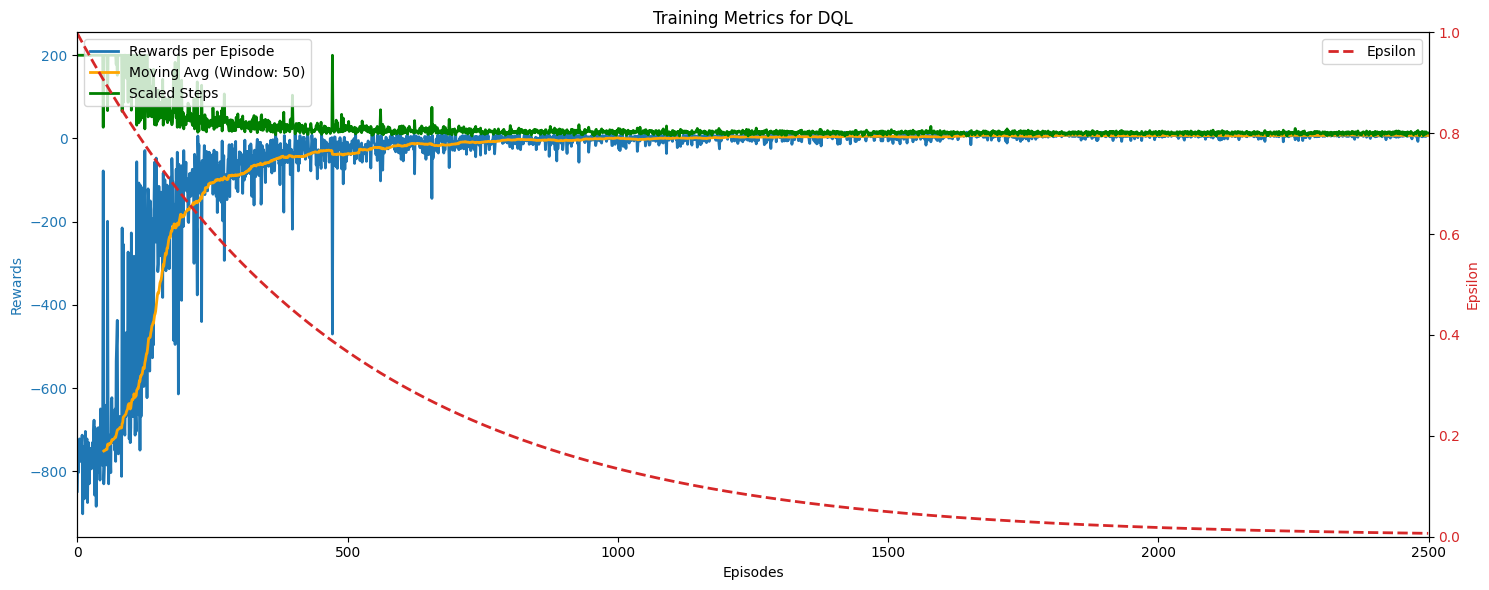

In [185]:
metrics.plot_metric('dql')

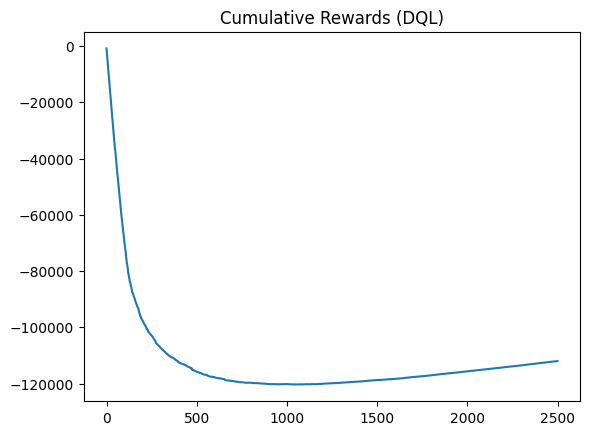

In [186]:
plt.plot(metrics['dql'].loc[:,'rewards'].cumsum())
plt.title("Cumulative Rewards (DQL)")
plt.show()

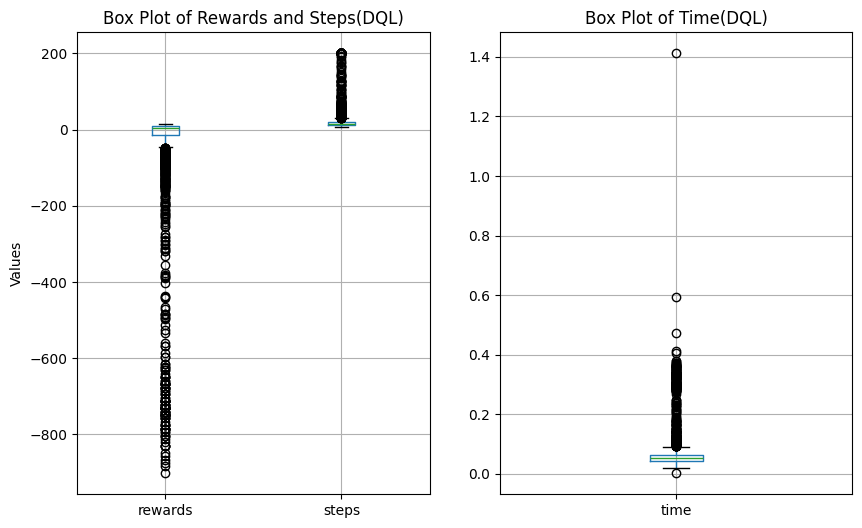

In [187]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
metrics['dql'][['rewards', 'steps']].boxplot(ax=axs[0])
metrics['dql'][['time']].boxplot(ax=axs[1])
axs[0].set_title("Box Plot of Rewards and Steps(DQL)")
axs[1].set_title("Box Plot of Time(DQL)")
axs[0].set_ylabel("Values")
plt.show()

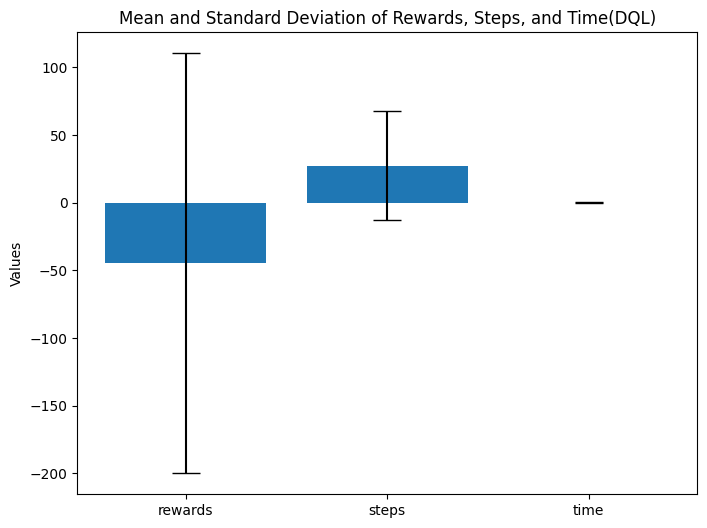

In [188]:
means = metrics['dql'][['rewards', 'steps', 'time']].mean()
stds = metrics['dql'][['rewards', 'steps', 'time']].std()

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(means.index, means, yerr=stds, capsize=10)
ax.set_title("Mean and Standard Deviation of Rewards, Steps, and Time(DQL)")
ax.set_ylabel("Values")

plt.show()

In [189]:
Video('./static/movies/dql/rl-video-episode-0.mp4')

# Model comparison against Heuristic & Random Policy

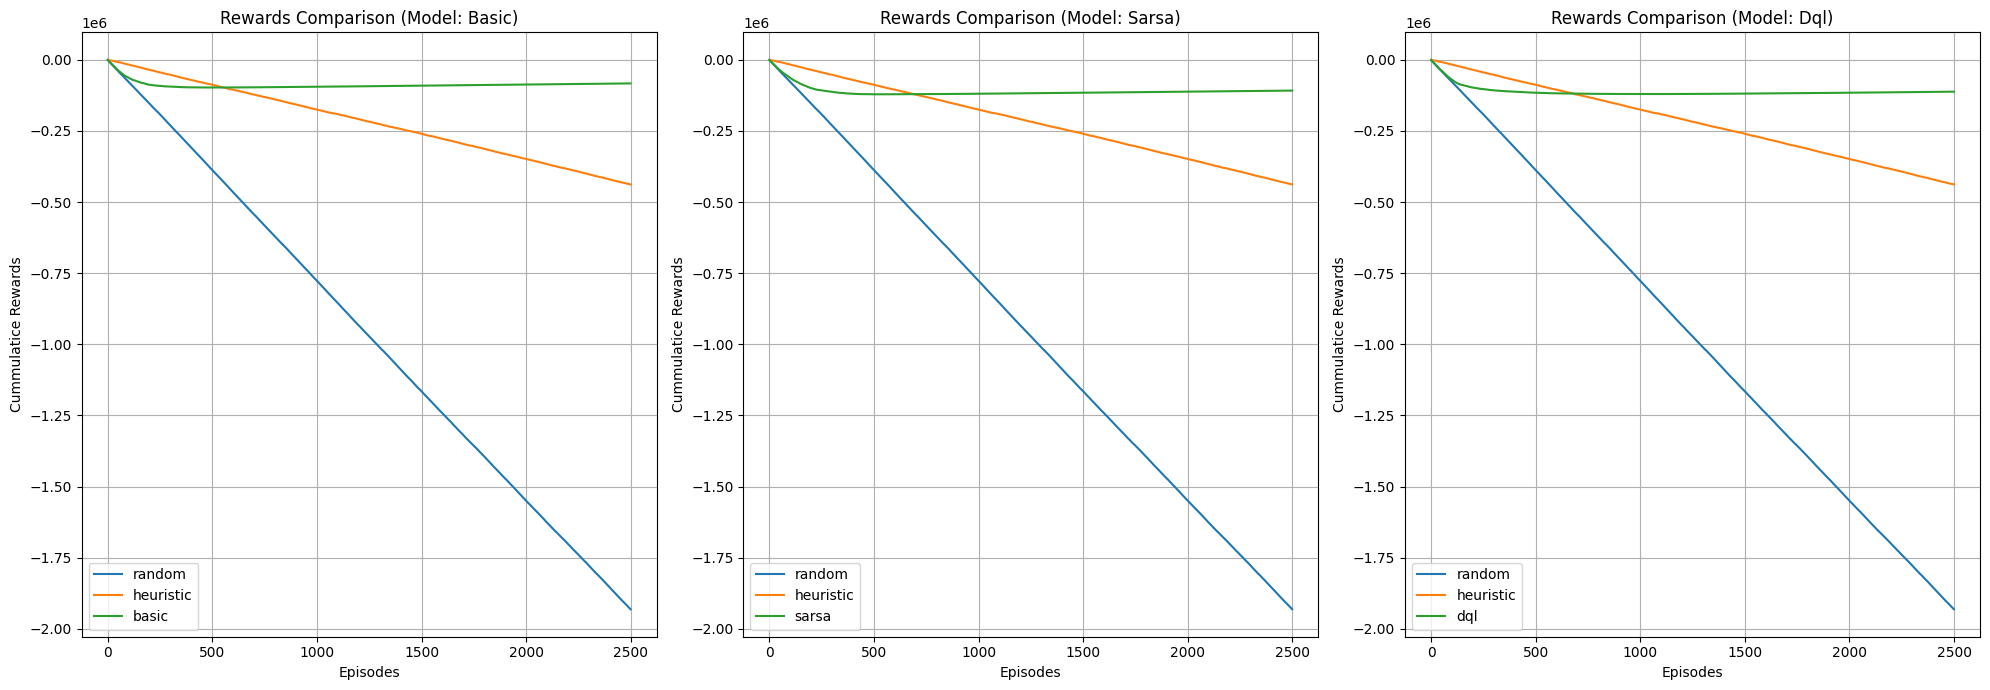

In [190]:
metrics.compare_rewards(['basic', 'sarsa', 'dql'], fig_size=(20, 7))

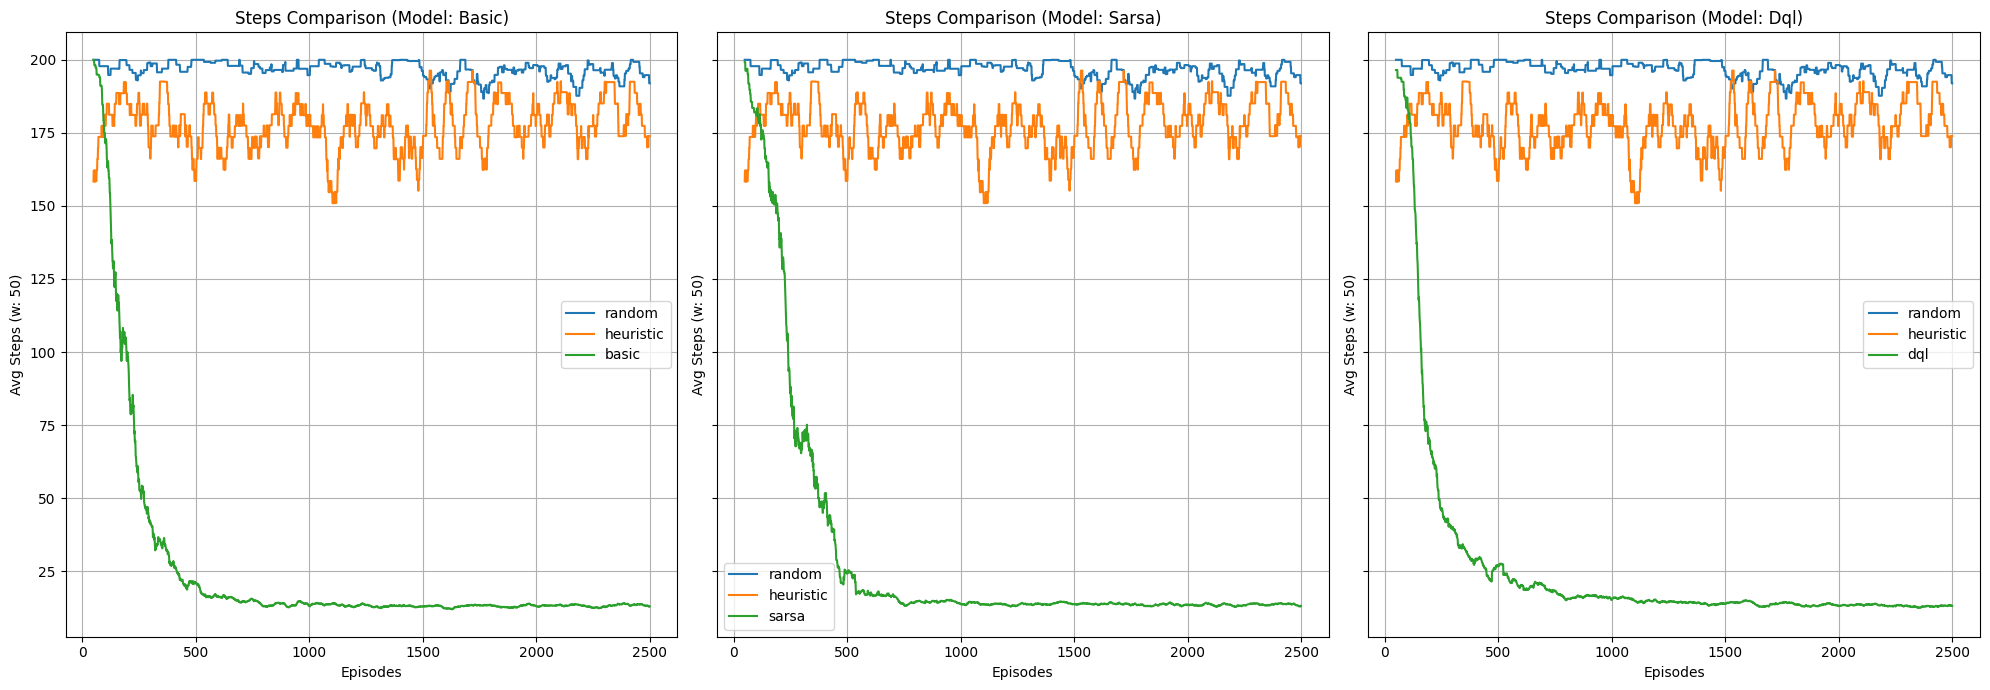

In [191]:
metrics.compare_steps(['basic', 'sarsa', 'dql'], fig_size=(20, 7))

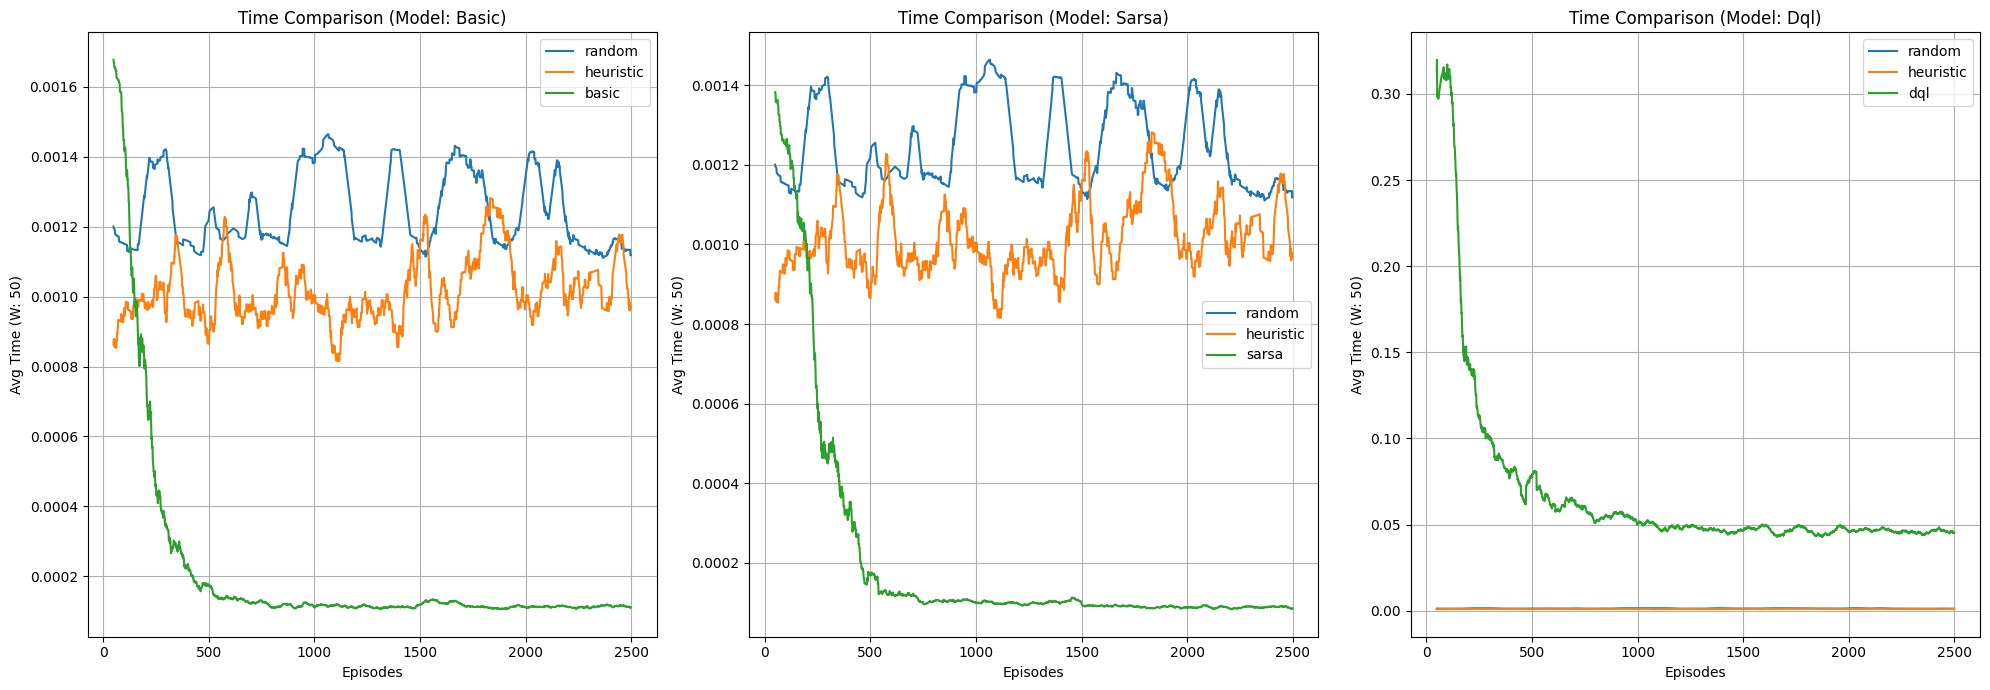

In [192]:
metrics.compare_time(['basic', 'sarsa', 'dql'], fig_size=(20, 7))

# Train the agents yourself.
If you want to train the agents yourself, feel free to do so by running the cell below. This will update the saved weight & metrics, thus if you re-run this notebook, the analysis / graphs will probably differ a bit.

**NB: Set `SHOULD_TRAIN` to `True` if you want to re-train the agents**

Feel free to adjust the number of episodes by tweaking the variables at the top of the notebook.

In [ ]:
from utils import create_progress_tracker
if SHOULD_TRAIN:
    print("Training agents...")
    for name, agent in agents.items():
        metrics = agent.train(TRAIN_EPISODES, MAX_STEPS_PER_EPISODE, create_progress_tracker(name.upper()))
        metrics.save(f'./static/metrics/{name}.csv')
        path = f'static/movies/{name}'
        agent.record_video(RECORD_N_EPISODES, path)
    print("All agents are trained, please re-run the notebook to see the results.")